# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_initial_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:
# Parameters
# --- Parameters fof Experiment ---
dim_exp = 32  # Dimension (e.g., 2D, 4D, 8D as in the paper)
data_points_exp = 40000 # Example number of data points
iterations_exp_initial = 1 # Iterations for initial training phase
iterations_exp_long = 500000 # Iterations for longer training phase
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 50 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Section 4.1.2: L1 Prior Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def evaluate_learned_J_HJ_approx(x_points, model):
    """
    Evaluates the learned prior J(x) using the method of characteristics
    for quadratic Hamiltonian H(p) = 0.5 * ||p||^2.
    
    The method of characteristics gives us:
    J(grad_psi(x)) = <x, grad_psi(x)> - 0.5 * ||grad_psi(x)||^2 - psi(x)
    
    To get J(x), we need to find the x' such that grad_psi(x') = x,
    then evaluate the formula at x'.
    
    For this specific problem where psi(x) = ||x||^2, we have grad_psi(x) = 2x,
    so to evaluate J(y), we need x = y/2.
    
    Args:
        x_points: numpy array of shape (N, dim) containing evaluation points
        model: trained LPN model
    
    Returns:
        J_est: numpy array of shape (N,) containing estimated J values
    """
    # To evaluate J(x), we need to find x' such that grad_psi(x') = x
    # For the learned psi approximating ||x||^2, grad_psi(x) ≈ 2x
    # So x' ≈ x/2 to get grad_psi(x') ≈ x
    
    # However, for a general learned model, we'd need to solve the inverse problem
    # For simplicity, assuming the model learned psi(x) ≈ ||x||^2 well,
    # we use the approximation x' = x/2
    
    x_prime = x_points / 2.0
    
    # Convert to tensor
    x_tensor = torch.from_numpy(x_prime).float().to(device)
    x_tensor.requires_grad_(True)
    
    # Get psi(x')
    psi_x = model.scalar(x_tensor)
    
    # Get gradient of psi at x'
    grad_psi = model(x_tensor)
    
    # Compute inner product <x', grad_psi(x')>
    inner_prod = torch.sum(x_tensor * grad_psi, dim=1, keepdim=True)
    
    # Compute ||grad_psi(x')||^2
    grad_psi_norm_sq = torch.sum(grad_psi * grad_psi, dim=1, keepdim=True)
    
    # Apply the formula: this gives J(grad_psi(x')) ≈ J(x)
    J_est = inner_prod - 0.5 * grad_psi_norm_sq - psi_x
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    #y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_J_HJ_approx(x1_0_points, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        #y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_J_HJ_approx(x2_0_points, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 32]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot with L2 Loss for the new experiment ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-4)

# Initial shorter training phase with a higher learning rate
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

# Longer training phase with a reduced learning rate
for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-4
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)
torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29835.12890625
iteration 0 loss 25886.728515625


iteration 5000 loss 174.32859802246094


iteration 10000 loss 20.40917205810547


iteration 15000 loss 12.254972457885742


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 7.204942226409912


iteration 25000 loss 5.323718070983887


iteration 30000 loss 2.9133706092834473


iteration 35000 loss 1.8024319410324097


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 1.257904052734375


iteration 45000 loss 1.1512686014175415


iteration 50000 loss 1.006197452545166


iteration 55000 loss 0.8922404050827026


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.8010178208351135


iteration 65000 loss 0.7883238196372986


iteration 70000 loss 0.7737264037132263


iteration 75000 loss 0.7604698538780212


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.7480193376541138


iteration 85000 loss 0.7467819452285767


iteration 90000 loss 0.7455223202705383


iteration 95000 loss 0.7443010807037354


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 0.7430990934371948


iteration 105000 loss 0.7430397868156433


iteration 110000 loss 0.7429807186126709


iteration 115000 loss 0.7429221868515015


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 0.7428643107414246


iteration 125000 loss 0.742863655090332


iteration 130000 loss 0.7428629398345947


iteration 135000 loss 0.7428625822067261


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 0.742861807346344


iteration 145000 loss 0.742861807346344


iteration 150000 loss 0.7428618669509888


iteration 155000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 0.7428619861602783


iteration 165000 loss 0.7428620457649231


iteration 170000 loss 0.7428620457649231


iteration 175000 loss 0.7428619861602783


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 0.7428619265556335


iteration 185000 loss 0.7428619265556335


iteration 190000 loss 0.7428619265556335


iteration 195000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 0.7428619265556335


iteration 205000 loss 0.7428619265556335


iteration 210000 loss 0.7428619265556335


iteration 215000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 0.7428619265556335


iteration 225000 loss 0.7428619265556335


iteration 230000 loss 0.7428619265556335


iteration 235000 loss 0.7428619265556335


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 0.7428619265556335


iteration 245000 loss 0.7428619265556335


iteration 250000 loss 0.7428619265556335


iteration 255000 loss 0.7428619265556335


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 0.7428619265556335


iteration 265000 loss 0.7428619265556335


iteration 270000 loss 0.7428619265556335


iteration 275000 loss 0.7428619265556335


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 0.7428619265556335


iteration 285000 loss 0.7428619265556335


iteration 290000 loss 0.7428619265556335


iteration 295000 loss 0.7428619265556335


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 0.7428619265556335


iteration 305000 loss 0.7428619265556335


iteration 310000 loss 0.7428619265556335


iteration 315000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 0.7428619265556335


iteration 325000 loss 0.7428619265556335


iteration 330000 loss 0.7428619265556335


iteration 335000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 0.7428619265556335


iteration 345000 loss 0.7428619265556335


iteration 350000 loss 0.7428619265556335


iteration 355000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 0.7428619265556335


iteration 365000 loss 0.7428619265556335


iteration 370000 loss 0.7428619265556335


iteration 375000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 0.7428619265556335


iteration 385000 loss 0.7428619265556335


iteration 390000 loss 0.7428619265556335


iteration 395000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 0.7428619265556335


iteration 405000 loss 0.7428619265556335


iteration 410000 loss 0.7428619265556335


iteration 415000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 0.7428619265556335


iteration 425000 loss 0.7428619265556335


iteration 430000 loss 0.7428619265556335


iteration 435000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 0.7428619265556335


iteration 445000 loss 0.7428619265556335


iteration 450000 loss 0.7428619265556335


iteration 455000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 0.7428619265556335


iteration 465000 loss 0.7428619265556335


iteration 470000 loss 0.7428619265556335


iteration 475000 loss 0.7428619265556335


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 0.7428619265556335


iteration 485000 loss 0.7428619265556335


iteration 490000 loss 0.7428619265556335


iteration 495000 loss 0.7428619265556335


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---


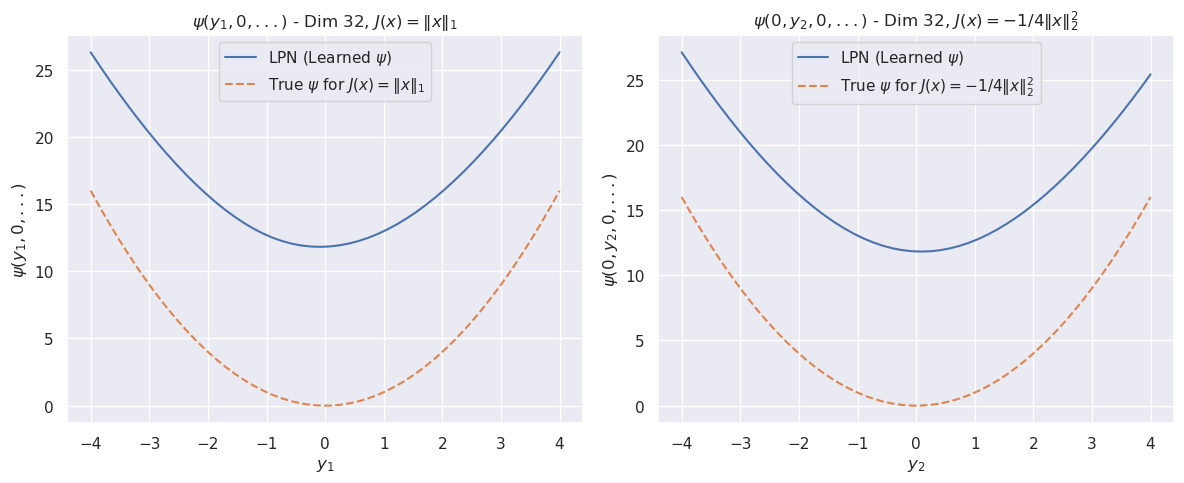

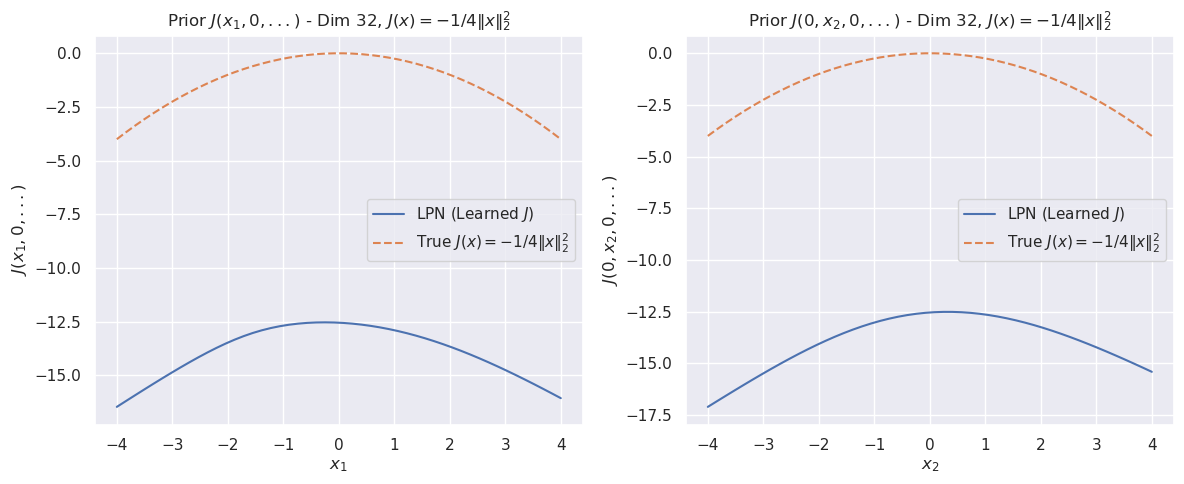

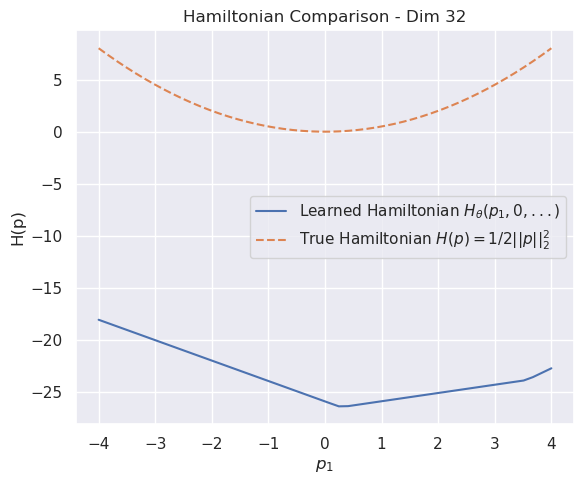

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")


Generated G samples: G_samples_tensor shape torch.Size([40000, 1])


In [10]:
# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 # Use a smaller learning rate for the long phase
for i in range(iterations_exp_long):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 27627.044921875
iteration 0 loss 21422.56640625


iteration 5000 loss 200.71878051757812


iteration 10000 loss 16.689844131469727


iteration 15000 loss 10.323111534118652


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 8.66366195678711


iteration 25000 loss 8.25769329071045


iteration 30000 loss 7.641632556915283


iteration 35000 loss 7.1574811935424805


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 6.736140251159668


iteration 45000 loss 6.662522315979004


iteration 50000 loss 6.573424816131592


iteration 55000 loss 6.482728004455566


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 6.3875203132629395


iteration 65000 loss 6.377452373504639


iteration 70000 loss 6.367380142211914


iteration 75000 loss 6.357335567474365


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 6.347275733947754


iteration 85000 loss 6.346372604370117


iteration 90000 loss 6.345472812652588


iteration 95000 loss 6.344573974609375


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 6.34367561340332


iteration 105000 loss 6.343663692474365


iteration 110000 loss 6.343652725219727


iteration 115000 loss 6.343639850616455


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 6.343628883361816


iteration 125000 loss 6.343628883361816


iteration 130000 loss 6.343628406524658


iteration 135000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 6.3436279296875


iteration 145000 loss 6.3436279296875


iteration 150000 loss 6.343628406524658


iteration 155000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 6.3436279296875


iteration 165000 loss 6.3436279296875


iteration 170000 loss 6.3436279296875


iteration 175000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 6.3436279296875


iteration 185000 loss 6.3436279296875


iteration 190000 loss 6.3436279296875


iteration 195000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 6.3436279296875


iteration 205000 loss 6.3436279296875


iteration 210000 loss 6.3436279296875


iteration 215000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 6.3436279296875


iteration 225000 loss 6.3436279296875


iteration 230000 loss 6.3436279296875


iteration 235000 loss 6.3436279296875


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 6.3436279296875


iteration 245000 loss 6.3436279296875


iteration 250000 loss 6.3436279296875


iteration 255000 loss 6.3436279296875


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 6.3436279296875


iteration 265000 loss 6.3436279296875


iteration 270000 loss 6.3436279296875


iteration 275000 loss 6.3436279296875


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 6.3436279296875


iteration 285000 loss 6.3436279296875


iteration 290000 loss 6.3436279296875


iteration 295000 loss 6.3436279296875


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 6.3436279296875


iteration 305000 loss 6.3436279296875


iteration 310000 loss 6.3436279296875


iteration 315000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 6.3436279296875


iteration 325000 loss 6.3436279296875


iteration 330000 loss 6.3436279296875


iteration 335000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 6.3436279296875


iteration 345000 loss 6.3436279296875


iteration 350000 loss 6.3436279296875


iteration 355000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 6.3436279296875


iteration 365000 loss 6.3436279296875


iteration 370000 loss 6.3436279296875


iteration 375000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 6.3436279296875


iteration 385000 loss 6.3436279296875


iteration 390000 loss 6.3436279296875


iteration 395000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 6.3436279296875


iteration 405000 loss 6.3436279296875


iteration 410000 loss 6.3436279296875


iteration 415000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 6.3436279296875


iteration 425000 loss 6.3436279296875


iteration 430000 loss 6.3436279296875


iteration 435000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 6.3436279296875


iteration 445000 loss 6.3436279296875


iteration 450000 loss 6.3436279296875


iteration 455000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 6.3436279296875


iteration 465000 loss 6.3436279296875


iteration 470000 loss 6.3436279296875


iteration 475000 loss 6.3436279296875


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 6.3436279296875


iteration 485000 loss 6.3436279296875


iteration 490000 loss 6.3436279296875


iteration 495000 loss 6.3436279296875


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


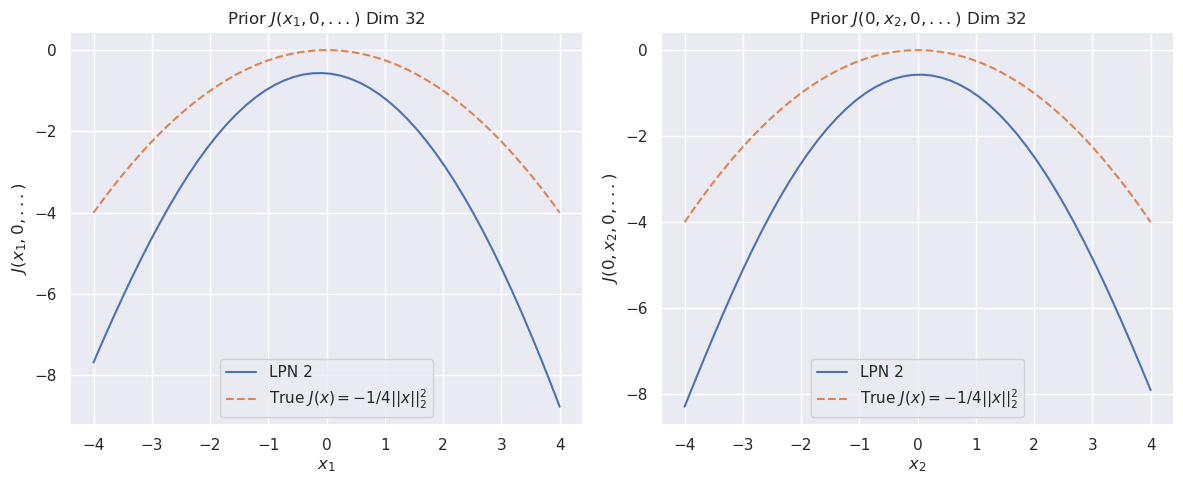

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)